In [119]:
import math
from typing import Any

import torch

from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch import functional as F

from torch.nn import Module
from scipy.stats import pareto 
from torch.distributions.pareto import Pareto
from torch.nn import init
seed=0
#torch.cuda.manual_seed_all(seed)
with torch.cuda.device('cuda:0'):
    torch.cuda.empty_cache()



In [120]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([
    transforms.ToTensor()
]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([
    transforms.ToTensor()
]))  
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size,shuffle=False)

In [121]:
weight_tuning=1
## initial =1
class Linear(Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(*, H_{in})` where :math:`*` means any number of
          dimensions including none and :math:`H_{in} = \text{in\_features}`.
        - Output: :math:`(*, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

    Attributes:
        weight: the learnable weights of the module of shape
            :math:`(\text{out\_features}, \text{in\_features})`. The values are
            initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
            :math:`k = \frac{1}{\text{in\_features}}`
        bias:   the learnable bias of the module of shape :math:`(\text{out\_features})`.
                If :attr:`bias` is ``True``, the values are initialized from
                :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
                :math:`k = \frac{1}{\text{in\_features}}`

    Examples::

        >>> m = nn.Linear(20, 30)
        >>> input = torch.randn(128, 20)
        >>> output = m(input)
        >>> print(output.size())
        torch.Size([128, 30])
    """
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        #if reset=True:
            
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        #init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound =weight_tuning/ math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)
            init.uniform_(self.weight, -bound,bound)
        #fan = _calculate_correct_fan(tensor, mode)
        #gain = calculate_gain(nonlinearity, a)
        #std = gain / math.sqrt(fan)
        #bound = math.sqrt(3.0) * std  # Calculate uniform bounds from standard deviation
        #with torch.no_grad():
            #return tensor.uniform_(-bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [122]:
import torch
import torchvision
#torch.cuda.is_available()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
#from torch.autograd.functional import jacobian
#import torch.autograd.functional
import time
import copy
import matplotlib.pyplot as plt
import pandas as pd
torch.set_default_dtype(torch.float64)
torch.set_default_dtype(torch.float64)
batch_size=100
input_size=784
output_size=784
hidden_state_size=10
N=28
no_of_layer=2



font = {
        'size'   : 14}
plt.rc('font', **font)

class AE(nn.Module):
    def __init__(self, input_shape,hidden_layer_shape,encoder_output_shape,n,xinit=torch.eye(batch_size,input_size),xfinal=torch.eye(batch_size,input_size),hidden=torch.eye(10,input_size)):
        super().__init__()
        self.encoder_input_layer = Linear(
            in_features=input_shape, out_features=hidden_layer_shape
        )
        self.hidden_layer=Linear(
            in_features=hidden_layer_shape, out_features=hidden_layer_shape
        )
        self.encoder_output_layer = Linear(
            in_features=hidden_layer_shape, out_features=encoder_output_shape
        )
        self.decoder_input_layer = Linear(
            in_features=encoder_output_shape, out_features=hidden_layer_shape
        )
        self.decoder_output_layer = Linear(
            in_features=hidden_layer_shape, out_features=input_shape
        )
        #self.encoder_input_layer.weight=torch.nn.Parameter(torch.rand(self.encoder_input_layer.weight.size))
        
        self.number_of_layers=n
        self.xinit=xinit
        self.xfinal=xfinal
        self.hidden=hidden

    def forward(self, features):
        reconstructed=self.internals(features)
        return reconstructed
    
    def internals(self,features):
        code=self.encoder(features)
        self.hidden=code
        #print(code)
       # print("hidden state maximum:"+str(torch.max(code)))
        reconstructed=self.decoder(code)
        return reconstructed
    
    def encoder(self,features):
        activation = self.encoder_input_layer(features)
        x = torch.relu(activation)
        self.xinit=x
        for i in range(self.number_of_layers):
            x=torch.relu(self.hidden_layer(x))
        code = self.encoder_output_layer(x)
        result = torch.relu(code)
        return code
    
    def decoder(self,code):
        activation = self.decoder_input_layer(code)
        x = torch.relu(activation)
        for i in range(self.number_of_layers):
             x=torch.relu(self.hidden_layer(x))
        self.xfinal=x
        activation = self.decoder_output_layer(x)
        reconstructed = torch.relu(activation)
        return reconstructed
    
    def xfinals(self):
        return self.xfinal
    
    def xinits(self):
        return self.xinit
    
    def hiddens(self):
        return self.hidden

In [123]:
def stats(tensor):
    # Calculate the mean
    mean = torch.mean(tensor)
    # Calculate the variance
    second = torch.mean(torch.pow(tensor,2))
    third = torch.mean(torch.pow(tensor,3))
    fourth=torch.mean(torch.pow(tensor,4))
    # Calculate the standard deviation
    var=torch.var(tensor)
    std = torch.sqrt(var)
    # Calculate the z-scores
    zscores = (tensor - mean) / std
    # Calculate the skewness
    skew = torch.mean(zscores ** 3)
    # Calculate the kurtosis
    kurt = torch.mean(zscores ** 4) - 3
    #Return the results as a tuple
    return mean, second, skew, kurt

In [124]:
def add_gaussian_noise(inputs,strength):
    #print(inputs.size())
    noise = torch.randn_like(inputs)*strength*torch.max(inputs)
    result=inputs + noise
    return result
def add_powerlaw_noise(input_size,batch_size,strength,images):
    ##input size here is the side of the image 28 
    m = Pareto(torch.tensor([1.0]), torch.tensor([1.0]))
    res=m.sample(images.size())

    temp=res/np.sqrt(res.var())/N/batch_size*strength
    noise=temp-temp.mean()
    #if print_bool:
     #   plt.title(powerlaw_noise print)
      #  plt.hist(noise.flatten(),density=True, bins='auto', histtype='stepfilled')
        
      #  plt.show()
    #print(noise[:,:,:,:,0].size())
    return noise[:,:,0]+images

def validation(test_loader):
    
    with torch.no_grad():

     #valid_loss = criterion(outputs, batch_features.view(batch_size,-1).to(device))
        loss=0
        for batch_features, _ in test_loader:
            #input=add_noise(batch_features,).view(100, -1).to(device)
            input_image=add_gaussian_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
            #batch_feature = batch_features.view(batch_size, -1)
            #input_image =add_powerlaw_noise(input_size,batch_size,noise_strength,batch_feature).view(batch_size, -1).to(device)
            batch_feature = batch_features.view(batch_size, -1).to(device)
            outputs = model(input_image)
            valid_loss = criterion(outputs, input_image.to(device)) 
            #accuracy+=kl_div(outputs,batch_features)/batch_size
            loss += valid_loss.item()
    return loss/len(test_loader)
            
def kl_div(output_image,input_image):
    accuracy=0
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    for i in range(len(input_image)):
        input_spectrum=torch.histogram(input_image[i].cpu(), bins=256, density=True)
        output_spectrum=torch.histogram(output_image[i].cpu(), bins=256, density=True)
        accuracy+=kl_loss(input_spectrum[i],output_spectrum[i])
    return accuracy/len(input_image)

def iteration(model,initial_inputs,no_of_repetition,epoch):
    y_pred=initial_inputs.to(device)
    for i in range(no_of_repetition):
        x_train=y_pred
        #if i==0:
           # name="progress asymptotic iteration:"+str(i)+" "
           # visualisation(x_train[0].cpu().detach(),epoch,name,False)
        #if i%5==1:
            #name="progress asymptotic iteration:"+str(i)+" "
            #visualisation(x_train[0].cpu().detach(),epoch,name,False)
        y_pred=model.internals(x_train)
    return x_train,y_pred,model 

def asymptotic_jacobian(model,initial_input,no_of_images,no_of_repetition):
    ave_jac=0
    overall_distribution=np.asarray([])

    jacobian=[]
    sorteds=np.asarray([])
    for j in range(no_of_repetition):
        #print("here")
        x_train=initial_input.to(device)
        y_pred=x_train
        mean_jacobian=0
        for i in range(no_of_images):
            x=x_train[i]
            res=torch.autograd.functional.jacobian(model.internals,x)
            distribution=np.asarray([])
            jacobian.append(res)
            sorted=np.asarray([])
            #if j==no_of_repetition-1:
             #   distribution,sorted=spectral_distribution(res.cpu())
              #  overall_distribution=np.concatenate((overall_distribution,distribution),axis=0)
              #  spectral=spectral_radius(sorted)
              #  sorteds=np.append(sorteds,spectral)

            norm=torch.norm(res).cpu()
            mean_jacobian+=1/np.sqrt(output_size)*norm
        mean_jacobian=mean_jacobian/no_of_images
        ave_jac+=mean_jacobian
    average_jacobian=ave_jac/no_of_repetition
    return average_jacobian,overall_distribution,jacobian,sorteds

def spectral_radius(jacobian,no_of_repetition,no_of_images):
    #result=[]
   
    #output=initial_input.to(device)
   # product=torch.eye(n=input_size,m=output_size).to(device)
    
    spectral=0

    
        
    #res=torch.autograd.functional.jacobian(model.internals,initial_input)
    #product=torch.matmul(product,res)
    #output=model(initial_input)
   # initial_input=output
    
    s,v=torch.linalg.eig(jacobian)
 #   #print(s)
    abs=torch.abs(s)
    
    spectral=torch.max(abs).item()
    return spectral

def poincare_plot(model,initial_input,dimension_vector,no_of_repetition,colour,epoch):
    xt=[]
    xtminus=[]
    
    output=initial_input
    
    for i in range(no_of_repetition):
        
        initial_input=output
        output=model(initial_input)
        
        xt.append(1/output_size*torch.dot(output,dimension_vector).item())
        xtminus.append(1/output_size*torch.dot(initial_input,dimension_vector).item())
    
    return xt,xtminus
  
    


def asymptotic_distance(xinfinity_unperturbed,xinfinity_perturbed,perturbation):
    result=[]
    for i in range(len(xinfinity_unperturbed)):
    
        sum=0
        
        for j in range(len(xinfinity_unperturbed[i])):
            
            temp=np.linalg.norm(xinfinity_unperturbed[i][j]-xinfinity_perturbed[i][j])
            sum+=temp
        
        result.append(1/output_size*1/len(xinfinity_unperturbed[i])*sum) 
    
    return result


def calculation(model,no_of_images,no_of_repetition,ave_jacobian,spectral_radiuses,image,epoch):
    spectral=0
    
    model_clone=AE(input_size,input_size,hidden_state_size,no_of_layer).to(device)
    model_clone.load_state_dict(copy.deepcopy(model.state_dict()))
    distributions=np.asarray([])
    x_train,y_pred,model_clone=iteration(model_clone,image,asymptotic_repetition,epoch)   
    #ave_jac,distributions,jacobian,sorteds= asymptotic_jacobian(model_clone,x_train,no_of_images,no_of_repetition)
    
    #np.savetxt("jacobian epoch"+str(epoch)+".txt",sorteds)
    #print("distribution size")
    #print(distributions.size)
    #print("sorted size")
    #print(sorteds.size)
    #average_jacobian.append(ave_jac)
    #x = [ele.real for ele in distributions]
    ## extract imaginary part
    #y = [ele.imag for ele in distributions]
    #plt.title("real and imaginary part of eigenvalue")
    #plt.scatter(x, y)
    #plt.ylabel('Imaginary')
    #plt.xlabel('Real')
    #plt.xscale("log")
    #plt.yscale("log")
    #plt.xlim(-1,1)
    #plt.ylim(-1,1)
    #plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"eigenvalue scatter plot.jpg",bbox_inches = 'tight')
    #plt.show()
    #plt.title("modulus of eigenvalue in log log plot ")
    #plt.hist(sorteds, density=True, bins='auto', histtype='stepfilled')
    #plt.yscale("log")
    #plt.xscale("log")

    #plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"eigenvalue distribution.jpg",bbox_inches = 'tight')
    #plt.show()

   # for i in range(no_of_images):
    
        #spectral+=spectral_radius(sorteds,no_of_repetition,no_of_images)
    #spectral=sorteds.mean()
    
    #spectral_radiuses.append(spectral)
    #print(spectral/no_of_images)
    
    return x_train,y_pred,average_jacobian,spectral_radiuses,model_clone


def asymptotic_iteration(model_new,initial_inputs,perturbed_inputs,no_of_repetition,no_of_image,cutoff):
    
    y_pred_unperturbed=initial_inputs.to(device)
    y_pred_perturbed=perturbed_inputs.to(device)
    #cutoff=[]
   
    #for j in range(no_of_image):
     
    #cutoff.append(torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j]))
        #print(cutoff[j])
    distance=[]
    hidden_layer=[]
    hiddens=[]
    chaos=0
 
    for i in range(no_of_repetition):
        x_train_unperturbed=y_pred_unperturbed
        y_pred_unperturbed=model_new.internals(x_train_unperturbed)
        
       
        x_train_perturbed=y_pred_perturbed
        y_pred_perturbed=model_new.internals(x_train_perturbed)
        
       # print(y_pred_perturbed,y_pred_unperturbed)
        
        #hidden = model.hiddens()
        #print(hidden)
        #print(torch.sum(hidden,dim=1).cpu().detach().numpy()/1000)
        #hidden_layer.append(torch.sum(hidden,dim=1)[0].cpu().detach().numpy()/10)
        #hiddens.append(torch.sum(hidden,dim=1).cpu().detach().numpy()/10)
        
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch)

        if i==no_of_repetition-1:
            diff=torch.zeros(1,device=device)
            temp=0
        #print(len(cutoff))
            for j in range(no_of_image):
                result=torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j])
            #print(np.isnan(result.cpu().detach().numpy()))
            #print(result)
                if np.isinf(result.cpu().detach().numpy()) or np.isnan(result.cpu().detach().numpy())  :
                    result=temp
                    print("infinity")
                temp=result
                diff+=result
            
            #print(j)
                if result>cutoff[j] and i==no_of_repetition-1:
                    chaos+=1
                if np.isinf(diff.cpu().detach().numpy()) or np.isnan(diff.cpu().detach().numpy()):
                    diff=torch.Tensor([1*10**38]).to(device)
                    print("infinity")
            #print("asymptotic calculation")
            #print(result.cpu())
            #print(diff.cpu())
            
            if diff.cpu().detach().numpy()<2**-52:
                diff=2**-52
                distance.append(diff)
                continue
            distance.append(diff.cpu().detach().numpy()/no_of_image)

    return distance,hidden_layer,chaos/no_of_image

def visualisation(xfinals,epoch,name,bool):
    plt.imshow(xfinals.reshape(N,N), cmap="gray")
    if bool:
        plt.savefig(str(name)+" epoch:"+str(epoch+1)+".jpg")
    plt.show()
    print(str(name)+" epoch:"+str(epoch+1)+".jpg")
    
def divergence(values):
    result=np.abs(values[-1]-values[-2])
    if result>np.abs(values[2]-values[1]):
        return 1
    return 0

def spectral_radius(sorted):
    if len(sorted)==0:
        return 0
    return sorted[0]

def spectral_distribution(input_matrix):
    result=[]
    count=0
    s,v=torch.linalg.eig(input_matrix)
    #return s
    for i in range(len(s)):
        if np.abs(s[i].cpu())<2**-52:
            count+=1
        
    sorted, indices=torch.sort(torch.abs(s),dim=-1,descending=True)
    #for index in indices.cpu():
     #   if index<=len(s)-count:
     #       result.append(s[index])
    #print(sorted)
    return s,sorted[:-count]


running
/raid/home/sichen/phd-project/self-organised-criticality/organised-result/tanh-1-adam/epoch:1.pt
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
[tensor(2.8271e-05, device='cuda:0'), tensor(2.8185e-05, device='cuda:0'), tensor(2.8033e-05, device='cuda:0'), tensor(2.8007e-05, device='cuda:0'), tensor(2.8978e-05, device='cuda:0'), tensor(2.7848e-05, device='cuda:0'), tensor(2.8686e-05, device='cuda:0'), tensor(2.8367e-05, device='cuda:0'), tensor(2.7726e-05, device='cuda:0'), tensor(2.8251e-05, device='cuda:0'), tensor(2.8122e-05, device='cuda:0'), tensor(2.8689e-05, device='cuda:0'), tensor(2.9326e-05, device='cuda:0'), tensor(2.7932e-05, device='cuda:0'), tensor(2.8506e-05, device='cuda:0'), tensor(2.8598e-05, device='cuda:0'), tensor(2.9215e-05, device='cuda:0'), tensor(2.8216e-05, device='cuda:0'), tensor(2.8357e-05, device='cuda:0'), tensor(2.8214e-05, device='cuda:0')]
here
done49
50

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2826: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


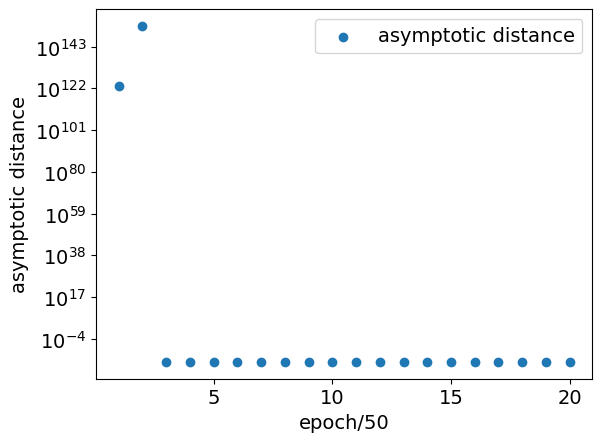

In [152]:
interval=50
no_of_repetition=100
asymptotic_repetition=50
criterion = nn.MSELoss()
noise_strength=10**-3
perturbation_strength=10**-6
import numpy as np  
import matplotlib.pyplot as plt
import torch
no_of_images=20
means=[]
vars=[]
skews=[]
kurtosises=[]
current_file=3
import os
#print(os.getcwd())
file=["relu-1-adam","relu-1-sgd","relu-2.5-adam","tanh-1-adam","tanh-2.5-adam","tanh-2.5-sgd","relu-2.5-sgd","tanh-1-sgd"]
#list of file to work on 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("running")
path="/raid/home/sichen/phd-project/self-organised-criticality/"
#current working directory
validation_loss=[]
training_loss=[]
asymptotic_dist=[]
epochs=1000
for epoch in range(epochs):
    #model = AE(input_size,output_size,hidden_state_size,no_of_layer).to(device)
    PATH=path+"organised-result/"+file[current_file]+"/epoch:"+str(epoch+1)+".pt"
    if epoch==0:
        print(PATH)
    #model.load_state_dict(torch.load(PATH))

    #loss = 0
    print(epoch)
    if epoch==0:
        for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        
        #distance,hidden,chaos,divergent=asymptotic_iteration(model_clone,x_train,perturbed_inputs,no_of_repetition,no_of_images,perturbation_strength)
       
            input_image =add_gaussian_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
        #input_image =add_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
        
        
        #input_image=batch_features.view(batch_size,-1).to(device)
      #  batch_feature=batch_features.view(batch_size,-1).to(device)
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
 
       # optimizer.zero_grad()
        
        # compute reconstructions
        #outputs = model(batch_features.view(batch_size,-1).to(device))
        #outputs = model(input_image)
        
        # compute training reconstruction loss
        
 
        #train_loss = criterion(outputs,input_image)
        

        #loss += train_loss.item()
    # compute the epoch training loss
   # loss = loss / len(train_loader)
    #print(loss)
    #training_loss.append(loss)
    #with torch.no_grad():
     #   accuracy=validation(test_loader)
     #   validation_loss.append(accuracy)
    if (epoch)%interval==interval-1:
        model = AE(input_size,output_size,hidden_state_size,no_of_layer).to(device)
        PATH=path+"organised-result/"+file[current_file]+"/epoch:"+str(epoch+1)+".pt"
        if epoch==0:
            print(PATH)
        model.load_state_dict(torch.load(PATH))
        perturbed_input=add_gaussian_noise(input_image,perturbation_strength)
        cutoffs=[]
        for j in range(no_of_images):
            cutoffs.append(torch.norm(perturbed_input[j]-input_image[j]))
        print(cutoffs)
        x_train_perturbed,y_pred_perturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,perturbed_input,epoch)
        x_train_unperturbed,y_pred_unperturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,input_image,epoch)
        distance,hidden,chaos=asymptotic_iteration(model_clone,y_pred_unperturbed,y_pred_perturbed,no_of_repetition,no_of_images,cutoffs)
                
        asymptotic_dist.append(distance[-1])
       # dimension_vector=torch.ones(input_size).to(device)
        #xt,xtminus=poincare_plot(model_clone,x_train[0],dimension_vector,no_of_repetition,colour,epoch)
       
        print('here')
        #perturbed_inputs=add_gaussian_noise(input_image,perturbation_strength).view(batch_size, -1).to(device)
        #distance,hidden,chaos,divergent=asymptotic_iteration(model_clone,x_train,perturbed_inputs,no_of_repetition,no_of_images,perturbation_strength*input_size)
        #print("percentage of chaos:",chaos)
        #asymptotic_dist.append(distance[-1])
        #print(distance[-1])
        #print("initial distance")
        #print(distance[0])
        #chao.append(chaos)
        #print(torch.norm(perturbed_inputs[0]-input_image[0]))
        #print(perturbation_strength*input_size)


        print("done"+str(epoch))
        
x=np.arange(1,epochs/interval+1)
plt.scatter(x,y=asymptotic_dist,label="asymptotic distance")

#labels="noise:"+str(noise_strength)+", perturbation:"+str(perturbation_strength)
plt.ylabel("asymptotic distance")
plt.xlabel("epoch/"+str(interval))
plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig(path+"organised-result/"+file[current_file]+"/asymptotic distance test.jpg")

plt.show()    

In [ ]:
import glob

# Define the pattern to search for
pattern = "*sgd*.txt"
print(path)
moment=["mean","variance","skewness","kurtosis"]
# Find all the files that match the pattern
files = glob.glob(path+"organised-result/"+pattern+moment[0])

for i in range (len(files)):
    my_file = open(files[i], "r")

    data = my_file.read()
    print(my_file)
  
    # replacing end of line('/n') with ' ' and
    # splitting the text it further when '.' is seen.
    data_into_list = data.replace('\n', ' ').split(" ")
    fig, ( (ax1, ax2,ax3,ax4), (ax5, ax6,ax7,ax8)) = plt.subplots (nrows=2, ncols=4,figsize=(40,20))
    for i in range(1):
            ax1.plot(x,means[1::10],label="mean"+file[i])
            ax1.legend(loc="best")
plt.show()


running
/raid/home/sichen/phd-project/self-organised-criticality/organised-result/relu-2.5-sgd/epoch:1.pt
weights


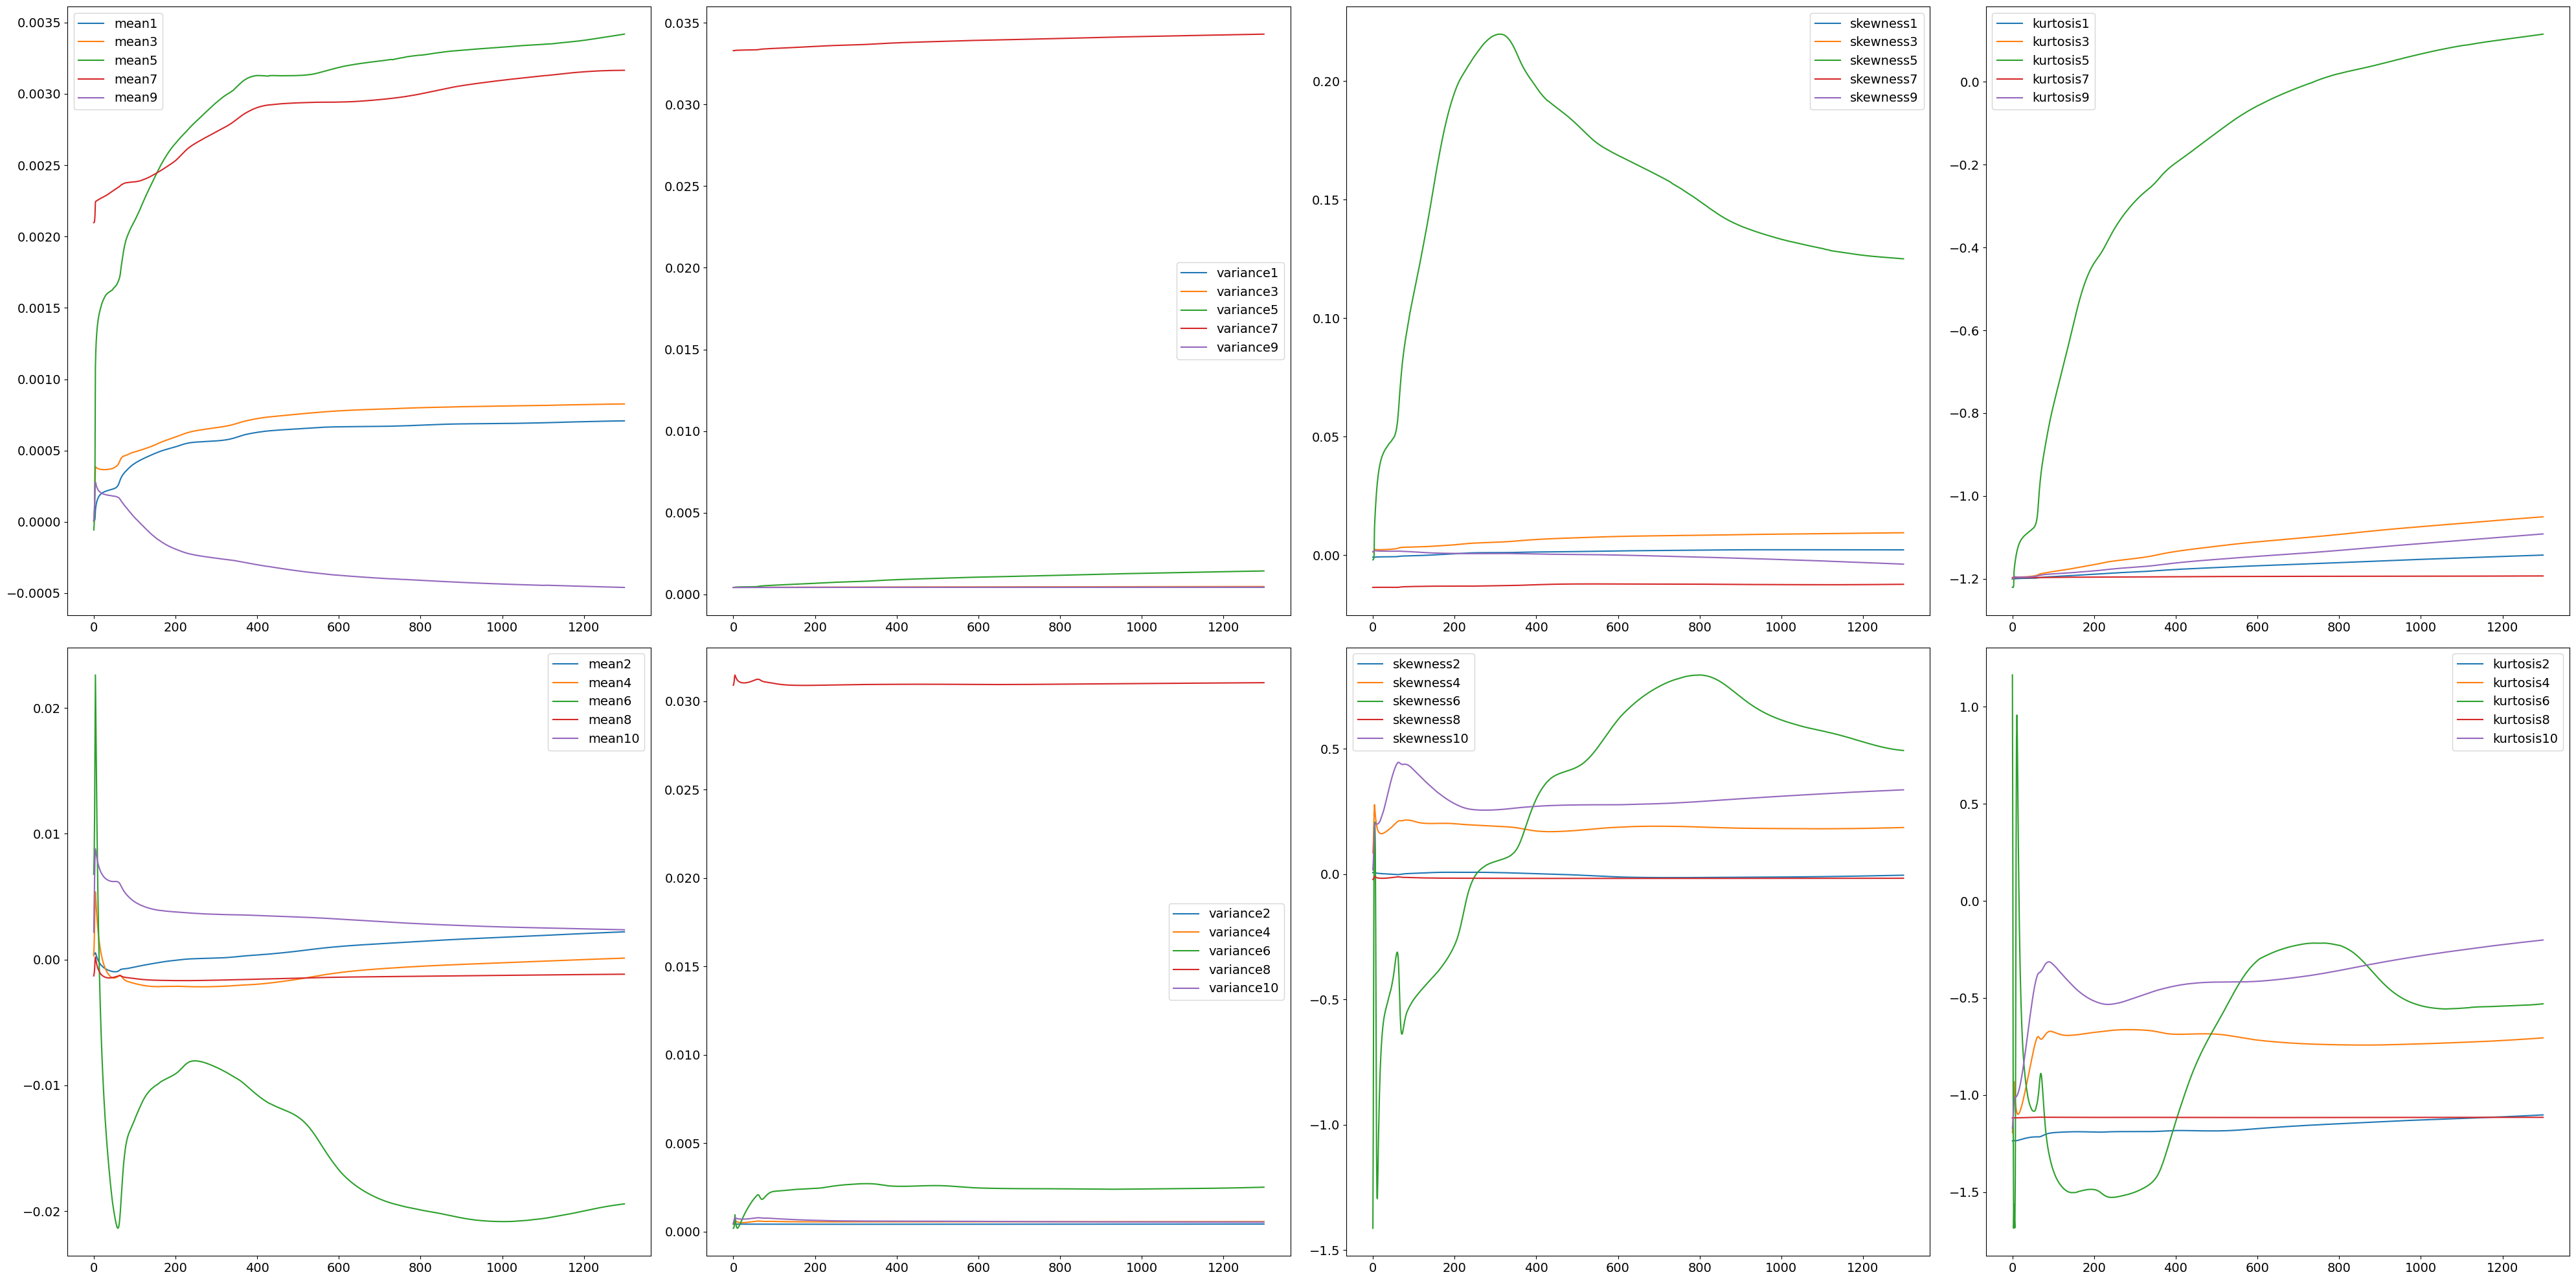

In [157]:
interval=50
no_of_repetition=100
asymptotic_repetition=50
criterion = nn.MSELoss()
noise_strength=10**-3
perturbation_strength=10**-6
import numpy as np  
import matplotlib.pyplot as plt
import torch
no_of_images=20
means=[]
vars=[]
skews=[]
kurtosises=[]
current_file=6
import os
#print(os.getcwd())
file=["relu-1-adam","relu-1-sgd","relu-2.5-adam","tanh-1-adam","tanh-2.5-adam","tanh-2.5-sgd","relu-2.5-sgd","tanh-1-sgd"]
#list of file to work on 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("running")
path="/raid/home/sichen/phd-project/self-organised-criticality/"
#current working directory
validation_loss=[]
training_loss=[]
asymptotic_dist=[]
epochs=1300
for epoch in range(epochs):
    model = AE(input_size,output_size,hidden_state_size,no_of_layer).to(device)
    PATH=path+"organised-result/"+file[current_file]+"/epoch:"+str(epoch+1)+".pt"
    if epoch==0:
        print(PATH)
    model.load_state_dict(torch.load(PATH))
#i=0
    for value in model.parameters():
    #match i:
        
    
    # Call the function and print the results
        mean, var, skew, kurt = stats(value)
        means.append(mean.cpu().detach().numpy())
        vars.append(var.cpu().detach().numpy())
        skews.append(skew.cpu().detach().numpy())
        kurtosises.append(kurt.cpu().detach().numpy())
        #print(f"Mean: {mean}")
        #print(f"Variance: {var}")
        #print(f"Skewness: {skew}")
        #print(f"Kurtosis: {kurt}")
        #print("end")

#means=np.resize(means,(10,1000))
x=np.arange(epochs)
print("weights")
fig, ( (ax1, ax2,ax3,ax4), (ax5, ax6,ax7,ax8)) = plt.subplots (nrows=2, ncols=4,figsize=(40,20))
for i in range(10):
    if i%2==0:
        ax1.plot(x,means[i::10],label="mean"+str(i+1))
        ax1.legend(loc="best")
        ax2.plot(x,vars[i::10],label="variance"+str(i+1))
        ax2.legend(loc="best")
        ax3.plot(x,skews[i::10],label="skewness"+str(i+1))
        ax3.legend(loc="best")
        ax4.plot(x,kurtosises[i::10],label="kurtosis"+str(i+1))
        ax4.legend(loc="best")
        #plt.show()
    else:
        ax5.plot(x,means[i::10],label="mean"+str(i+1))
        ax5.legend(loc="best")
        ax6.plot(x,vars[i::10],label="variance"+str(i+1))
        ax6.legend(loc="best")
        ax7.plot(x,skews[i::10],label="skewness"+str(i+1))
        ax7.legend(loc="best")
        ax8.plot(x,kurtosises[i::10],label="kurtosis"+str(i+1))
        ax8.legend(loc="best")
fig.tight_layout()

plt.savefig(path+"organised-result/"+file[current_file]+"/"+"new weights(kurtosis-skew).jpg")
np.savetxt(path+"organised-result/"+file[current_file]+"mean.txt",means)
np.savetxt(path+"organised-result/"+file[current_file]+"variance.txt",vars)
np.savetxt(path+"organised-result/"+file[current_file]+"skewness.txt",skews)
np.savetxt(path+"organised-result/"+file[current_file]+"kurtosis.txt",kurtosises)
plt.show()

